### Import libs

In [2]:
import pandas as pd

### Load data

In [171]:
pd_dataset = pd.read_csv("./data/ds_salaries.csv");
pd_dataset.head(10)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M
5,2023,SE,FT,Applied Scientist,222200,USD,222200,US,0,US,L
6,2023,SE,FT,Applied Scientist,136000,USD,136000,US,0,US,L
7,2023,SE,FT,Data Scientist,219000,USD,219000,CA,0,CA,M
8,2023,SE,FT,Data Scientist,141000,USD,141000,CA,0,CA,M
9,2023,SE,FT,Data Scientist,147100,USD,147100,US,0,US,M


### pyspark init

In [172]:
pd_dataset.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size'],
      dtype='object')

In [173]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext

import findspark
findspark.init()

In [174]:
spark = SparkSession.builder.appName('Assignment').getOrCreate()
spark

In [180]:
spark_data = spark.read.option('header', 'true').csv("./data/ds_salaries.csv")
spark_data.show()

+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+
|work_year|experience_level|employment_type|           job_title|salary|salary_currency|salary_in_usd|employee_residence|remote_ratio|company_location|company_size|
+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+
|     2023|              SE|             FT|Principal Data Sc...| 80000|            EUR|        85847|                ES|         100|              ES|           L|
|     2023|              MI|             CT|         ML Engineer| 30000|            USD|        30000|                US|         100|              US|           S|
|     2023|              MI|             CT|         ML Engineer| 25500|            USD|        25500|                US|         100|              US|           S|
|     2023

In [187]:

from pyspark.sql.functions import col, when


# Casting relevant columns to double
spark_data = spark_data.withColumn("salary_in_usd", col("salary_in_usd").cast("double"))
spark_data = spark_data.withColumn("company_size_int", 
                                   when(col("company_size") == "L", 3)
                                   .when(col("company_size") == "M", 2)
                                   .when(col("company_size") == "S", 1)
                                   .otherwise(0))
                                   
spark_data = spark_data.withColumn("job_title_int", 
                                   when(col("job_title").contains("Analyst"), 1)
                                   .when(col("job_title").contains("Engineer"), 2)
                                   .when(col("job_title").contains("Scientist"), 3)
                                   .otherwise(0)
                                  )

spark_data = spark_data.withColumn("experience_level_int", 
                                   when(col("experience_level") == "EN", 1)
                                   .when(col("experience_level") == "MI", 2)
                                   .when(col("experience_level") == "SE", 3)
                                   .when(col("experience_level") == "EX", 4)
                                   .otherwise(0)
                                  )

spark_data = spark_data.withColumn("work_year", col("work_year").cast("int"))

#filter data which doesn't fall under any categories
filtered_spark_data = spark_data
filtered_spark_data = filtered_spark_data.filter(col("job_title_int") != 0)
filtered_spark_data = filtered_spark_data.filter(col("experience_level_int") != 0)
filtered_spark_data = filtered_spark_data.filter(col("company_size_int") != 0)

print(f"{spark_data.count() - filtered_spark_data.count()} data among {spark_data.count()} removed because it doesn't falls under any Categories")

366 data among 3755 removed because it doesn't falls under any Categories


In [190]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Selecting relevant features for clustering
features = ['salary_in_usd','company_size_int', 'job_title_int','experience_level_int', 'work_year',]

# Assemble features into a single vector column
vec_assembler = VectorAssembler(inputCols=features, outputCol="features")
spark_data_assembled = vec_assembler.transform(filtered_spark_data).select("features")
spark_data_assembled.show(5)

print(f"Total Number of rows: {spark_data_assembled.count()}")

+--------------------+
|            features|
+--------------------+
|[85847.0,3.0,3.0,...|
|[30000.0,1.0,2.0,...|
|[25500.0,1.0,2.0,...|
|[175000.0,2.0,3.0...|
|[120000.0,2.0,3.0...|
+--------------------+
only showing top 5 rows

Total Number of rows: 3389


In [192]:
# Scaling features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(spark_data_assembled)
spark_data_scaled = scaler_model.transform(spark_data_assembled)
spark_data_scaled.show(10)

+--------------------+--------------------+
|            features|     scaled_features|
+--------------------+--------------------+
|[85847.0,3.0,3.0,...|[1.37870819160035...|
|[30000.0,1.0,2.0,...|[0.48180187715366...|
|[25500.0,1.0,2.0,...|[0.40953159558061...|
|[175000.0,2.0,3.0...|[2.81051095006304...|
|[120000.0,2.0,3.0...|[1.92720750861465...|
|[222200.0,3.0,3.0...|[3.56854590345147...|
|[136000.0,3.0,3.0...|[2.18416850976327...|
|[219000.0,2.0,3.0...|[3.51715370322175...|
|[141000.0,2.0,3.0...|[2.26446882262222...|
|[147100.0,2.0,3.0...|[2.36243520431013...|
+--------------------+--------------------+
only showing top 10 rows



In [200]:

# Scaling features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(spark_data_assembled)
spark_data_scaled = scaler_model.transform(spark_data_assembled)
spark_data_scaled.show(10)

+--------------------+--------------------+
|            features|     scaled_features|
+--------------------+--------------------+
|[85847.0,3.0,3.0,...|[1.37870819160035...|
|[30000.0,1.0,2.0,...|[0.48180187715366...|
|[25500.0,1.0,2.0,...|[0.40953159558061...|
|[175000.0,2.0,3.0...|[2.81051095006304...|
|[120000.0,2.0,3.0...|[1.92720750861465...|
|[222200.0,3.0,3.0...|[3.56854590345147...|
|[136000.0,3.0,3.0...|[2.18416850976327...|
|[219000.0,2.0,3.0...|[3.51715370322175...|
|[141000.0,2.0,3.0...|[2.26446882262222...|
|[147100.0,2.0,3.0...|[2.36243520431013...|
+--------------------+--------------------+
only showing top 10 rows



### K means cultering 

In [204]:
from pyspark.ml.clustering import KMeans

# KMeans model with k=4 clusters
kmeans = KMeans().setK(4).setSeed(42)
model = kmeans.fit(spark_data_scaled)

# Add the cluster labels to the original DataFrame
spark_data_result_kmean = model.transform(spark_data_scaled)

spark_data_result_kmean.show(10)

+--------------------+--------------------+----------+
|            features|     scaled_features|prediction|
+--------------------+--------------------+----------+
|[85847.0,3.0,3.0,...|[1.37870819160035...|         2|
|[30000.0,1.0,2.0,...|[0.48180187715366...|         2|
|[25500.0,1.0,2.0,...|[0.40953159558061...|         2|
|[175000.0,2.0,3.0...|[2.81051095006304...|         0|
|[120000.0,2.0,3.0...|[1.92720750861465...|         3|
|[222200.0,3.0,3.0...|[3.56854590345147...|         1|
|[136000.0,3.0,3.0...|[2.18416850976327...|         3|
|[219000.0,2.0,3.0...|[3.51715370322175...|         1|
|[141000.0,2.0,3.0...|[2.26446882262222...|         3|
|[147100.0,2.0,3.0...|[2.36243520431013...|         3|
+--------------------+--------------------+----------+
only showing top 10 rows



### BisectingKMeans Alogrithm

In [205]:
from pyspark.ml.clustering import BisectingKMeans

# Bisecting k-means model with k=4 clusters
bisecting_kmeans = BisectingKMeans().setK(4).setSeed(42)
bisecting_model = bisecting_kmeans.fit(spark_data_scaled)

# Add the cluster labels to the original DataFrame
spark_data_result_bisecting = bisecting_model.transform(spark_data_scaled)

spark_data_result_bisecting.show(10)

+--------------------+--------------------+----------+
|            features|     scaled_features|prediction|
+--------------------+--------------------+----------+
|[85847.0,3.0,3.0,...|[1.37870819160035...|         1|
|[30000.0,1.0,2.0,...|[0.48180187715366...|         0|
|[25500.0,1.0,2.0,...|[0.40953159558061...|         0|
|[175000.0,2.0,3.0...|[2.81051095006304...|         2|
|[120000.0,2.0,3.0...|[1.92720750861465...|         1|
|[222200.0,3.0,3.0...|[3.56854590345147...|         3|
|[136000.0,3.0,3.0...|[2.18416850976327...|         1|
|[219000.0,2.0,3.0...|[3.51715370322175...|         3|
|[141000.0,2.0,3.0...|[2.26446882262222...|         2|
|[147100.0,2.0,3.0...|[2.36243520431013...|         2|
+--------------------+--------------------+----------+
only showing top 10 rows



### Gaussian Mixture Model (GMM)

In [207]:
from pyspark.ml.clustering import GaussianMixture

# Gaussian Mixture Model with k=4 clusters
gmm = GaussianMixture().setK(4).setSeed(42)
gmm_model = gmm.fit(spark_data_scaled)

# Add the cluster labels to the original DataFrame
spark_data_result_gmm = gmm_model.transform(spark_data_scaled)

spark_data_result_gmm.show(10)

+--------------------+--------------------+--------------------+----------+
|            features|     scaled_features|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|[85847.0,3.0,3.0,...|[1.37870819160035...|[3.68701775897167...|         1|
|[30000.0,1.0,2.0,...|[0.48180187715366...|[1.28076600317672...|         2|
|[25500.0,1.0,2.0,...|[0.40953159558061...|[1.36449571654285...|         2|
|[175000.0,2.0,3.0...|[2.81051095006304...|[1.57211421150408...|         1|
|[120000.0,2.0,3.0...|[1.92720750861465...|[1.94559143551548...|         1|
|[222200.0,3.0,3.0...|[3.56854590345147...|[8.62124306699161...|         1|
|[136000.0,3.0,3.0...|[2.18416850976327...|[1.05120630074497...|         1|
|[219000.0,2.0,3.0...|[3.51715370322175...|[4.31829287315914...|         1|
|[141000.0,2.0,3.0...|[2.26446882262222...|[1.48012974995793...|         1|
|[147100.0,2.0,3.0...|[2.36243520431013...|[1.42552412831421...|         1|
+-----------

### Eveluating cultering modals

In [208]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Assuming you have already fitted k-means, bisecting k-means, and GMM models
kmeans_evaluator = ClusteringEvaluator()
bisecting_evaluator = ClusteringEvaluator()
gmm_evaluator = ClusteringEvaluator()

# Evaluate k-means model
kmeans_silhouette = kmeans_evaluator.evaluate(spark_data_result_kmean)
print(f"K-Means Silhouette Score: {kmeans_silhouette}")

# Evaluate bisecting k-means model
bisecting_silhouette = bisecting_evaluator.evaluate(spark_data_result_bisecting)
print(f"Bisecting K-Means Silhouette Score: {bisecting_silhouette}")

# Evaluate GMM model
gmm_silhouette = gmm_evaluator.evaluate(spark_data_result_gmm)
print(f"GMM Silhouette Score: {gmm_silhouette}")

K-Means Silhouette Score: 0.684153276224908
Bisecting K-Means Silhouette Score: 0.6550821030302532
GMM Silhouette Score: -0.12436731211598781


The silhouette score is a metric used to calculate the goodness of a clustering technique. It provides a measure of how well-separated clusters are and ranges from -1 to 1. A higher silhouette score indicates better-defined clusters.

Here's how to interpret the silhouette scores:

K-Means Silhouette Score: 0.684

A score of 0.684 is relatively high and suggests that the clusters produced by the k-means algorithm are well-defined and distinct from each other.
Bisecting K-Means Silhouette Score: 0.655

A score of 0.655 is also quite good. It indicates that the clusters created by the bisecting k-means algorithm are well-separated, though slightly less so compared to k-means.
GMM Silhouette Score: -0.124

A negative silhouette score (-0.124) for GMM suggests that the clusters produced by the Gaussian Mixture Model might be overlapping or poorly defined. This negative score indicates that GMM might not be the best fit for your data based on the number of clusters specified.
In general, when interpreting silhouette scores:

Scores close to 1 indicate well-defined clusters.
Scores around 0 suggest overlapping clusters or clusters that are too close.
Negative scores indicate incorrect clustering, and the data points might be better off in a different cluster.

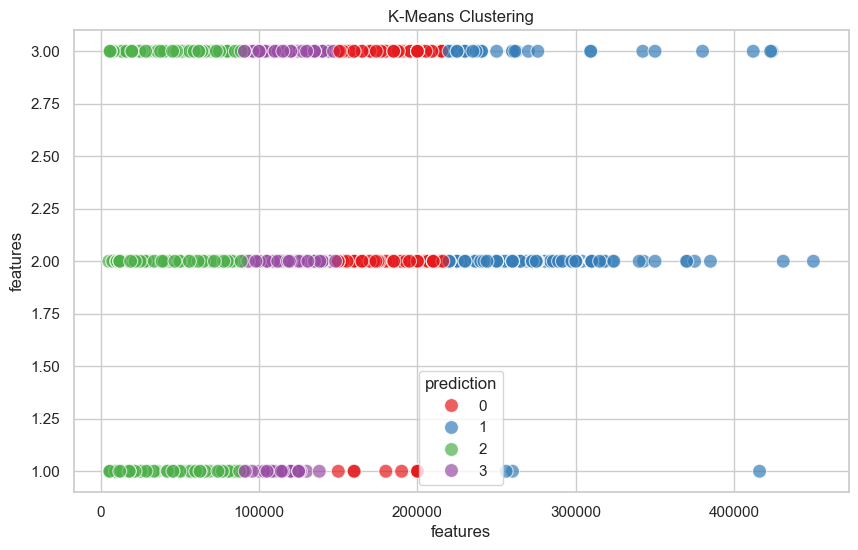

In [209]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extracting features and cluster labels from the result DataFrame
features_and_clusters = spark_data_result_kmean.select("features", "prediction").toPandas()

# Plotting the data using seaborn scatterplot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    x=features_and_clusters["features"].apply(lambda x: x[0]),
    y=features_and_clusters["features"].apply(lambda x: x[1]),
    hue=features_and_clusters["prediction"],
    palette="Set1",
    s=100,
    alpha=0.7,
)

scatter_plot.set_title("K-Means Clustering")
plt.show()

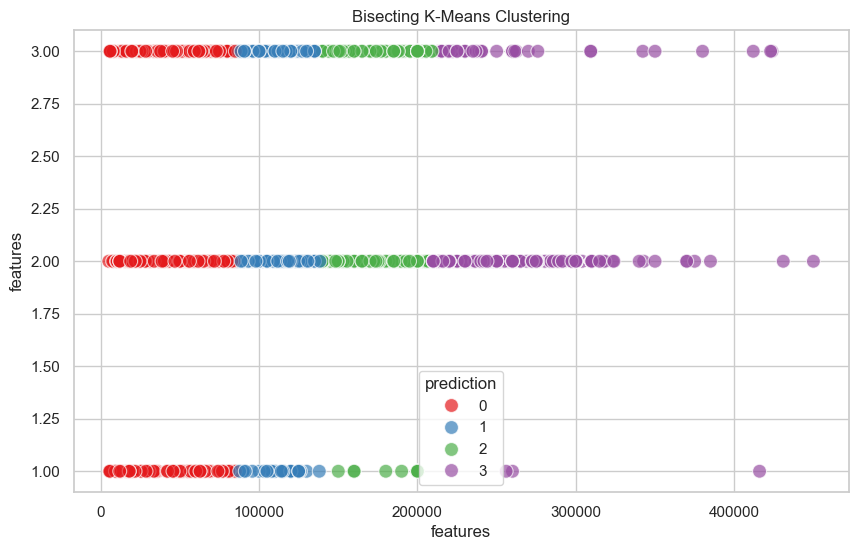

In [211]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extracting features and cluster labels from the result DataFrame
features_and_clusters = spark_data_result_bisecting.select("features", "prediction").toPandas()

# Plotting the data using seaborn scatterplot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    x=features_and_clusters["features"].apply(lambda x: x[0]),
    y=features_and_clusters["features"].apply(lambda x: x[1]),
    hue=features_and_clusters["prediction"],
    palette="Set1",
    s=100,
    alpha=0.7,
)

scatter_plot.set_title("Bisecting K-Means Clustering")
plt.show()

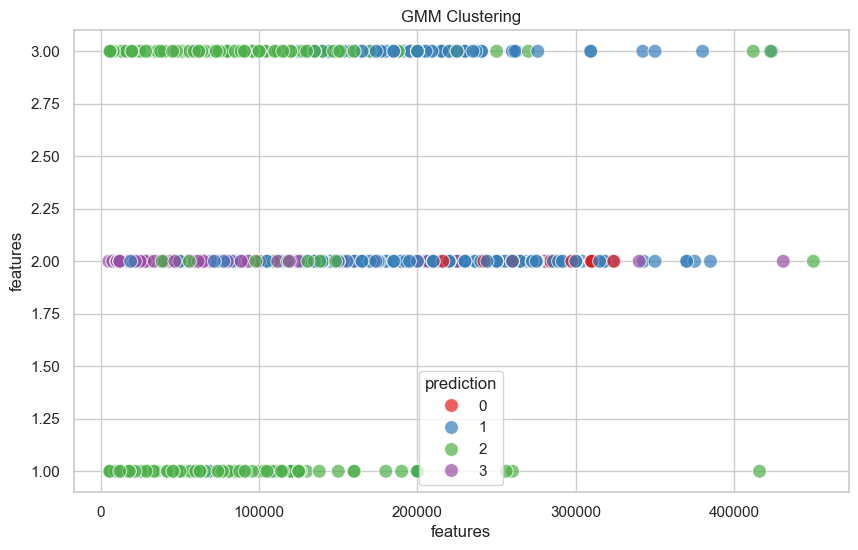

In [213]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extracting features and cluster labels from the result DataFrame
features_and_clusters = spark_data_result_gmm.select("features", "prediction").toPandas()

# Plotting the data using seaborn scatterplot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    x=features_and_clusters["features"].apply(lambda x: x[0]),
    y=features_and_clusters["features"].apply(lambda x: x[1]),
    hue=features_and_clusters["prediction"],
    palette="Set1",
    s=100,
    alpha=0.7,
)

scatter_plot.set_title("GMM Clustering")
plt.show()

In [ ]:

# Plotting the distribution of each feature for each cluster
for feature in features:
    plt.figure(figsize=(10, 6))
    box_plot = sns.boxplot(x="prediction", y=feature, data=features_and_clusters, palette="Set1")
    box_plot.set_title(f"{feature} Distribution across Clusters")
    plt.show()


### Join the cluster labels to the original DataFrame - K mean (best among 3)


In [218]:
# Selecting relevant features for clustering
features = ['salary_in_usd','company_size_int', 'job_title_int','experience_level_int', 'work_year',]

# Assemble features into a single vector column
vec_assembler = VectorAssembler(inputCols=features, outputCol="features")
spark_data_assembled = vec_assembler.transform(filtered_spark_data)
spark_data_assembled.show(5)


spark_data_with_clusters = spark_data_assembled.join(spark_data_result_kmean.select("features", "prediction"), on="features")

# Display the first few rows of the DataFrame with cluster labels
spark_data_with_clusters.show(10)

+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+----------------+-------------+--------------------+--------------------+
|work_year|experience_level|employment_type|           job_title|salary|salary_currency|salary_in_usd|employee_residence|remote_ratio|company_location|company_size|company_size_int|job_title_int|experience_level_int|            features|
+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+----------------+-------------+--------------------+--------------------+
|     2023|              SE|             FT|Principal Data Sc...| 80000|            EUR|      85847.0|                ES|         100|              ES|           L|               3|            3|                   3|[85847.0,3.0,3.0,...|
|     2023|              MI|             CT|    

### order by prediction and drop the converted colmns 

In [227]:
# Sort the cluster_analysis DataFrame by the "prediction" column
spark_data_with_clusters = spark_data_with_clusters.orderBy("prediction")


# Drop multiple columns
columns_to_drop = ["features", "experience_level_int", "job_title_int", "company_size_int"]
spark_data_with_clusters = spark_data_with_clusters.drop(*columns_to_drop)

# Display the sorted cluster analysis results
spark_data_with_clusters.show()

+---------+----------------+---------------+-----------------+------+---------------+-------------+------------------+------------+----------------+------------+----------+
|work_year|experience_level|employment_type|        job_title|salary|salary_currency|salary_in_usd|employee_residence|remote_ratio|company_location|company_size|prediction|
+---------+----------------+---------------+-----------------+------+---------------+-------------+------------------+------------+----------------+------------+----------+
|     2023|              EN|             FT|Applied Scientist|213660|            USD|     213660.0|                US|           0|              US|           L|         0|
|     2023|              SE|             FT|   Data Scientist|170000|            USD|     170000.0|                US|           0|              US|           M|         0|
|     2023|              SE|             FT|   Data Scientist|175000|            USD|     175000.0|                CA|         100|    

### save above result in .csv file

In [232]:
#add job category to reuslt since modal was created this way
spark_data_with_clusters = spark_data_with_clusters.withColumn("job_title_category", 
                                   when(col("job_title").contains("Analyst"), "Analyst")
                                   .when(col("job_title").contains("Engineer"), "Engineer")
                                   .when(col("job_title").contains("Scientist"), "Scientist")
                                   .otherwise("Others")
                                  )

#convert dataframe to pandas 
spark_data_with_clusters_pd = spark_data_with_clusters.toPandas()


# save df 
spark_data_with_clusters_pd.to_csv("./data/ds_salaries_clusters.csv", header=True, index=False)

In [170]:
spark.stop()